In [18]:
import pandas as pd
import seaborn as sns
import re
import os
import numpy as np
from matplotlib_venn import venn3
import matplotlib.pyplot as plt
from palaeoPSM.psm_read import FragPipeRun, filter_psms
from palaeoPSM.psm_to_long import psm_to_long
from Bio import SeqIO
import plotly.express as px
from upsetplot import from_contents, UpSet

In [19]:
orthrus_db = '../orthrus_db/fish_combined_pt1.fasta'
orthrus_db_dict = SeqIO.to_dict(SeqIO.parse(orthrus_db, 'fasta'))

contams = '../databases/contams.fasta'
contams_dict = SeqIO.to_dict(SeqIO.parse(contams, "fasta"))

fp_run = '../fp_results/fish_st_orthrus_extra/'
save_folder = '../fish_analysis_results/'

gene_descr = {}
up_regex = re.compile('(sp|tr)\|([OPQ][0-9][A-Z0-9]{3}[0-9]|[A-NR-Z][0-9]([A-Z][A-Z0-9]{2}[0-9]){1,2})\|\w+? ([\w, \.\- ()]+) OS')
for seq_id, seqrec in orthrus_db_dict.items():
    m = up_regex.search(seqrec.description)
    if m is not None:
        gene_descr[seq_id]  = m.group(4)


In [20]:
def export_legend(legend, filename="legend.png"):
    fig = legend.figure
    fig.canvas.draw()
    bbox = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename + '.svg', dpi=400, bbox_inches=bbox, format='svg')
    fig.savefig(filename + '.png', dpi=400, bbox_inches=bbox, format='png')

In [21]:
fish_st = FragPipeRun(
    path=fp_run,
    db=orthrus_db_dict,
    run_id='fish_st_orthrusdb',
    contams=contams_dict,
    format='tsv',
    decoy_tag='rev_',
    n_scans_path='../mzml_data_fish/n_scans.csv',
    prob_column='Probability'
)

Reading # of scans from ../mzml_data_fish/n_scans.csv


In [22]:
exp_design = pd.read_csv('../briquettes_exp_design.csv')

exp_design['clay'] = exp_design['clay'].map({'A3': 'Aegina', 'R': 'Commercial'})

exp_design = fish_st.n_scans.merge(exp_design, on='sample')
exp_design['label'] = exp_design['clay'] + ' + ' + exp_design['temper'] + ' - ' + exp_design['firing']
exp_design['fabric'] = exp_design['clay'] + ' + ' + exp_design['temper']
exp_design = exp_design.sort_values(['cooking', 'sample' ,'firing'])
exp_design.loc[exp_design['sample']=='blank_1', 'label'] = 'blank_1'
exp_design.loc[exp_design['sample']=='blank_2', 'label'] = 'blank_2'
exp_design.loc[exp_design['sample']=='blank_1', 'fabric'] = 'blank_1'
exp_design.loc[exp_design['sample']=='blank_2', 'fabric'] = 'blank_2'
print(exp_design['sample'].values)

['fish_1A' 'fish_1B' 'fish_2A' 'fish_2B' 'fish_3A' 'fish_3B' 'fish_5A'
 'fish_6A' 'fish_7A' 'fish_8A' 'fish_8B' 'blank_1' 'blank_2' 'control_1A'
 'control_1B' 'control_2A' 'control_2B' 'control_3A' 'control_3B'
 'control_5A' 'control_6A' 'control_7A' 'control_8A' 'control_8B']


In [23]:
exp_design

,sample,n_ms1scans,n_ms2scans,clay,clay_name,temper,firing,cooking,label,fabric
1,fish_1A,1057,8005,Aegina,Aegina (A3),quartz,low T,anchovy,Aegina + quartz - low T,Aegina + quartz
9,fish_1B,1129,8940,Aegina,Aegina (A3),quartz,high T,anchovy,Aegina + quartz - high T,Aegina + quartz
18,fish_2A,1038,8523,Aegina,Aegina (A3),none,low T,anchovy,Aegina + none - low T,Aegina + none
3,fish_2B,1085,7986,Aegina,Aegina (A3),none,high T,anchovy,Aegina + none - high T,Aegina + none
10,fish_3A,1043,7727,Commercial,Commercial (R),quartz,low T,anchovy,Commercial + quartz - low T,Commercial + quartz
23,fish_3B,1138,7709,Commercial,Commercial (R),quartz,high T,anchovy,Commercial + quartz - high T,Commercial + quartz
16,fish_5A,1051,8644,Commercial,Commercial (R),high Ca grog,low T,anchovy,Commercial + high Ca grog - low T,Commercial + high Ca grog
14,fish_6A,1091,7688,Commercial,Commercial (R),low Ca grog,low T,anchovy,Commercial + low Ca grog - low T,Commercial + low Ca grog
21,fish_7A,1033,7617,Commercial,Commercial (R),straw,low T,anchovy,Commercial + straw - low T,Commercial + straw
4,fish_8A,1145,8292,Commercial,Commercial (R),none,low T,anchovy,Commercial + none - low T,Commercial + none


In [24]:
protein_df = []
restrict_fp_run = fp_run
for _, sample in exp_design['sample'].items():
    sample_fp_protein = os.path.join(restrict_fp_run, sample, 'protein.tsv')
    protein = pd.read_csv(sample_fp_protein, sep='\t')
    protein['sample'] = sample
    # Filter by probability
    protein = protein.loc[protein['Protein Probability'] > 0.95,:]
    protein_df.append(protein)
protein_df = pd.concat(protein_df)
# Remove reverse and contams
protein_df = protein_df[~protein_df['Protein'].str.startswith('rev_')]
protein_df = protein_df[~protein_df['Protein'].isin(contams_dict)]

# Group by protein and keep the MAX coverage
protein_df = protein_df.merge(exp_design, how='left', on='sample')

In [25]:
# Define colors for fabrics
briquette_colors = {
    'blank_1': '#DDDDDD',
    'blank_2': '#DDDDDD',
    'Aegina + quartz - low T': '#CC6677',
    'Aegina + quartz - high T': '#CC6677',
    'Aegina + none - low T': '#999933',
    'Aegina + none - high T': '#999933',
    'Commercial + quartz - low T': '#AA4499',
    'Commercial + quartz - high T': '#AA4499',
    'Commercial + high Ca grog - low T': '#44AA99',
    'Commercial + low Ca grog - low T': '#88CCEE',
    'Commercial + straw - low T': '#117733',
    'Commercial + none - low T': '#DDCC77',
    'Commercial + none - high T': '#DDCC77',
}


briquette_colors = {
    'blank_1': '#DDDDDD',
    'blank_2': '#DDDDDD',
    'Aegina + quartz - low T': '#CC6677', 
    'Aegina + quartz - high T': '#801f2d',
    'Aegina + none - low T': '#c3c33b',
    'Aegina + none - high T': '#897b38',
    'Commercial + quartz - low T': '#cb3cb4',
    'Commercial + quartz - high T': '#853e7a',
    'Commercial + high Ca grog - low T': '#44AA99',
    'Commercial + low Ca grog - low T': '#88CCEE',
    'Commercial + straw - low T': '#117733',
    'Commercial + none - low T': '#e4e268',
    'Commercial + none - high T': '#b7b72e',#8e953a
    'empty': '#dddddd'
}


fabric_colors = {
    'blank_1': '#DDDDDD',
    'blank_2': '#DDDDDD',
    'Aegina + quartz': '#CC6677',
    'Aegina + none': '#999933',
    'Commercial + quartz': '#AA4499',
    'Commercial + high Ca grog': '#44AA99',
    'Commercial + low Ca grog': '#88CCEE',
    'Commercial + straw': '#117733',
    'Commercial + none': '#DDCC77',
}


fabric_hatch = {
    '1A': '...',
    '1B': '',
    '2A': '...',
    '2B': '',
    '3A': '...',
    '3B': '',
    '5A': '...',
    '6A': '...',
    '7A': '...',
    '8A': '...',
    '8B': ''
}

hatches = ['1A', '1B', '2A', '2B',
           '3A', '3B', '5A', '6A', '7A', '8A', '8B']

protein_colors = {
    'Alpha-S1-casein': '#44AA99',
    'Alpha-S2-casein': '#117733',
    'Alpha-lactalbumin': '#AA4499',
    'Beta-casein': '#CC6677',
    'Beta-lactoglobulin': '#332288',
    'Kappa-casein': '#DDCC77',
    'Lactotransferrin': '#88CCEE' 
}

In [26]:
psm_data = fish_st.read(
    n_procs=1,
    save_path=None,
    remove_contams=None,
    whitelist=None,
    remove_decoy=False,
    fdr_threshold=None)

	Reading sample control_3B ... Done
	Reading sample fish_6A ... Done
	Reading sample control_2A ... Done
	Reading sample fish_5A ... Done
	Reading sample fish_2B ... Done
	Reading sample control_3A ... Done
	Reading sample fish_3B ... Done
	Reading sample control_5A ... Done
	Reading sample control_8B ... Done
	Reading sample fish_2A ... Done
	Reading sample control_1A ... Done
	Reading sample fish_1B ... Done
	Reading sample control_6A ... Done
	Reading sample control_7A ... Done
	Reading sample blank_1 ... Done
	Reading sample fish_3A ... Done
	Reading sample control_1B ... Done
	Reading sample fish_8A ... Done
	Reading sample fish_7A ... Done
	Reading sample blank_2 ... Done
	Reading sample control_8A ... Done
	Reading sample fish_8B ... Done
	Reading sample control_2B ... Done
	Reading sample fish_1A ... Done
Could not extract PTM from  (PeakApex: 0.0000); Mod1: Pyro-glu from Q/Loss of ammonia, Mod2: deuterated methyl ester (PeakApex: 0.0152)
Could not extract PTM from  (PeakApex: 

<Axes: xlabel='hyperscore', ylabel='Count'>

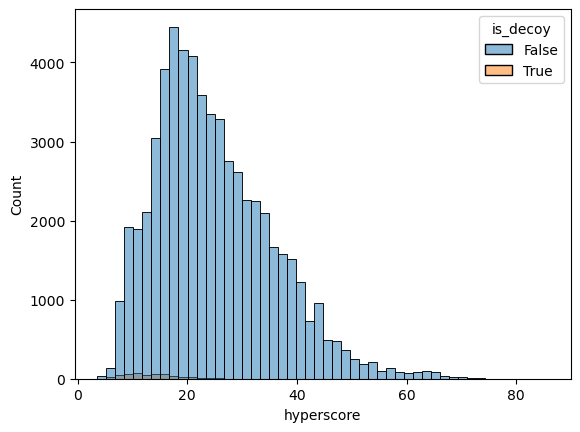

In [27]:
sns.histplot(psm_data, x='hyperscore', hue='is_decoy', stat='count', bins=50)

In [28]:
def filter_prots(prot, other_prots, contams):
    if prot.startswith('rev_'):
        return False
    if contams is not None and prot in contams:
        return False
    for p in other_prots:
        if p.startswith('rev_'):
            return False
        if contams is not None and p in contams:
            return False
    return True



In [29]:
psm_data = psm_data.merge(exp_design, on='sample', how='left')

In [30]:
psm_data = psm_data.loc[psm_data['q'] < 0.05,:]

decoy_mask = (
    psm_data[['prot_id','other_prot_ids']]
    .apply(lambda x: filter_prots(x['prot_id'], x['other_prot_ids'], contams=None), axis=1))
decoy_contam_mask = (
    psm_data[['prot_id','other_prot_ids']]
    .apply(lambda x: filter_prots(x['prot_id'], x['other_prot_ids'], contams=contams_dict), axis=1))

psm_data_w_contams = psm_data.loc[decoy_mask, :]
psm_data = psm_data.loc[decoy_contam_mask,:]

In [31]:
psm_data['protein'] = psm_data['prot_id'].map(gene_descr, na_action='ignore')

In [32]:
psm_data_by_sample = psm_data.groupby('sample')
psm_data_by_sample_prot = psm_data.groupby(['sample', 'protein'])

psm_data_by_sample_w_contams = psm_data_w_contams.groupby('sample')


In [33]:
def summarise_psms(psm_df):
    prop = 100 * psm_df.shape[0]/psm_df.iloc[0]
    return prop

ids_per_sample_w_contams = (
    psm_data_by_sample_w_contams['n_ms2scans']
    .aggregate('count').reset_index()
    .rename(columns={'n_ms2scans': 'count_ids'})
    .merge(exp_design, on='sample', how='left')
    .sort_values('sample')
)
ids_per_sample_w_contams['prop_ids'] = ids_per_sample_w_contams['count_ids'] / ids_per_sample_w_contams['n_ms2scans']


In [39]:
ids_per_sample = (
    psm_data_by_sample['n_ms2scans']
    .aggregate('count').reset_index()
    .rename(columns={'n_ms2scans': 'count_ids'})
    .merge(exp_design, on='sample', how='left')
    .sort_values('sample')
)
ids_per_sample['prop_ids'] = ids_per_sample['count_ids'] / ids_per_sample['n_ms2scans']

# By protein

In [43]:
ids_per_sample_prot = (
    psm_data_by_sample_prot['n_ms2scans']
    .aggregate(summarise_psms).reset_index()
    .rename(columns={'n_ms2scans': 'prop_ids'})
    .merge(exp_design, on='sample', how='left')
    # .query('cooking in ["anchovy"]')
    .sort_values(['sample','protein'])
)


# Coverage

In [44]:
protein_df['Gene'].drop_duplicates().sort_values().values.tolist()

['ACTB',
 'ALDOA',
 'ATP2A1',
 'ATP5F1B',
 'CKMT2',
 'COII',
 'COL1A1',
 'COL1A2',
 'COL2A1',
 'COL5A1',
 'COL5A2',
 'CS',
 'Col1a1',
 'Col2a1',
 'EGR3',
 'ENO1',
 'ENO3',
 'EXN66_Car004680',
 'HBA',
 'HF521_022719',
 'HbA',
 'HbB',
 'IRJ41_011016',
 'JOB18_029262',
 'KOW79_009259',
 'LDHA',
 'LDHB',
 'LOC100534412',
 'LOC100703906',
 'LOC101156021',
 'LOC103030463',
 'LOC103357262',
 'LOC105910077',
 'LOC105910226',
 'LOC106565368',
 'LOC106569363',
 'LOC106610502',
 'LOC107385311',
 'LOC107386128',
 'LOC107395776',
 'LOC107555938',
 'LOC107562837',
 'LOC107660614',
 'LOC107737758',
 'LOC108259776',
 'LOC108922518',
 'LOC108928921',
 'LOC108930024',
 'LOC109048132',
 'LOC109867664',
 'LOC113056234',
 'LOC113065017',
 'LOC114862877',
 'LOC115053334',
 'LOC115160980',
 'LOC115171514',
 'LOC120066269',
 'Ldhb',
 'MB',
 'MYH4',
 'MYH4_0',
 'MYH4_2',
 'MYH4_3',
 'MYH6',
 'MYL1',
 'Myh4_0',
 'Myh4_1',
 'PDE3B',
 'TPI1',
 'TPIS',
 'TPISB',
 'TPM1',
 'TPM1-1',
 'TPM1-2',
 'TPM2',
 'Tpm1_0',
 

In [45]:
protein_plot = protein_df.copy()

In [46]:

muscle_proteins = {
    'sp|Q90339|MYSS_CYPCA': 'myosin\nheavy chain\nfast skeletal\nmuscle',
    #'tr|A0A8C8BSV0|A0A8C8BSV0_ONCTS': 'myosin\nheavy chain 6',
    'tr|A0A8C2JNZ0|A0A8C2JNZ0_CYPCA': 'myosin\nlight chain 1',
    # 'sp|P79818|ACTB_ORYLA': 'actin 1',
    'sp|P49055|ACTS_CARAU': 'actin alpha\nskeletal muscle',
    'sp|P13104|TPM1_DANRE': 'tropomyosin-1'
}


other_proteins = {
    'sp|P02594|CALM_ELEEL': 'calmodulin',
    'sp|Q9PVM4|HBAA_SERQU': 'hemoglobin\nalpha',
    'sp|Q9PVM2|HBBA_SERQU': 'hemoglobin\nbeta',
    'tr|Q5NT96|Q5NT96_PAROL': 'col1a1'
}



In [47]:
protein_plot['protein_label'] = ''
muscle_mask = protein_plot['Protein'].isin(muscle_proteins)
protein_plot.loc[muscle_mask, 'protein_label'] = (
    protein_plot
    .loc[muscle_mask, 'Protein']
    .map(muscle_proteins, na_action=None))
protein_plot.loc[muscle_mask, 'protein_type'] = 'muscle'

other_mask = protein_plot['Protein'].isin(other_proteins)
protein_plot.loc[other_mask, 'protein_label'] = (
    protein_plot
    .loc[other_mask, 'Protein']
    .map(other_proteins, na_action=None))
protein_plot.loc[other_mask, 'protein_type'] = 'other'

In [48]:
selec_protein_df = protein_plot.loc[protein_plot['protein_label'] != '',:]

In [49]:
selec_protein_df = selec_protein_df.sort_values(['protein_label', 'label'])

In [51]:
all_hatches = hatches
ax0hatches = []
for h in all_hatches:
    ax0hatches.extend([h]*4)



ax1hatches = [
    '1A',
    '1B', '1B', '1B', '1B',

    '2A', '2A',
    '2B', '2B', '2B',
    
    '3A', '3A', '3A', '3A',
    '3B', '3B', '3B', '3B',
    
    '5A', '5A', '5A',
    '6A', '6A', '6A',
    '7A', '7A', '7A', '7A',
    
    '8A', '8A', '8A',
    '8B', '8B', '8B', '8B'
]

ax1hatches.extend(all_hatches)



/tmp/ipykernel_31225/3760258071.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), size=16)
/tmp/ipykernel_31225/3760258071.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), size=16)


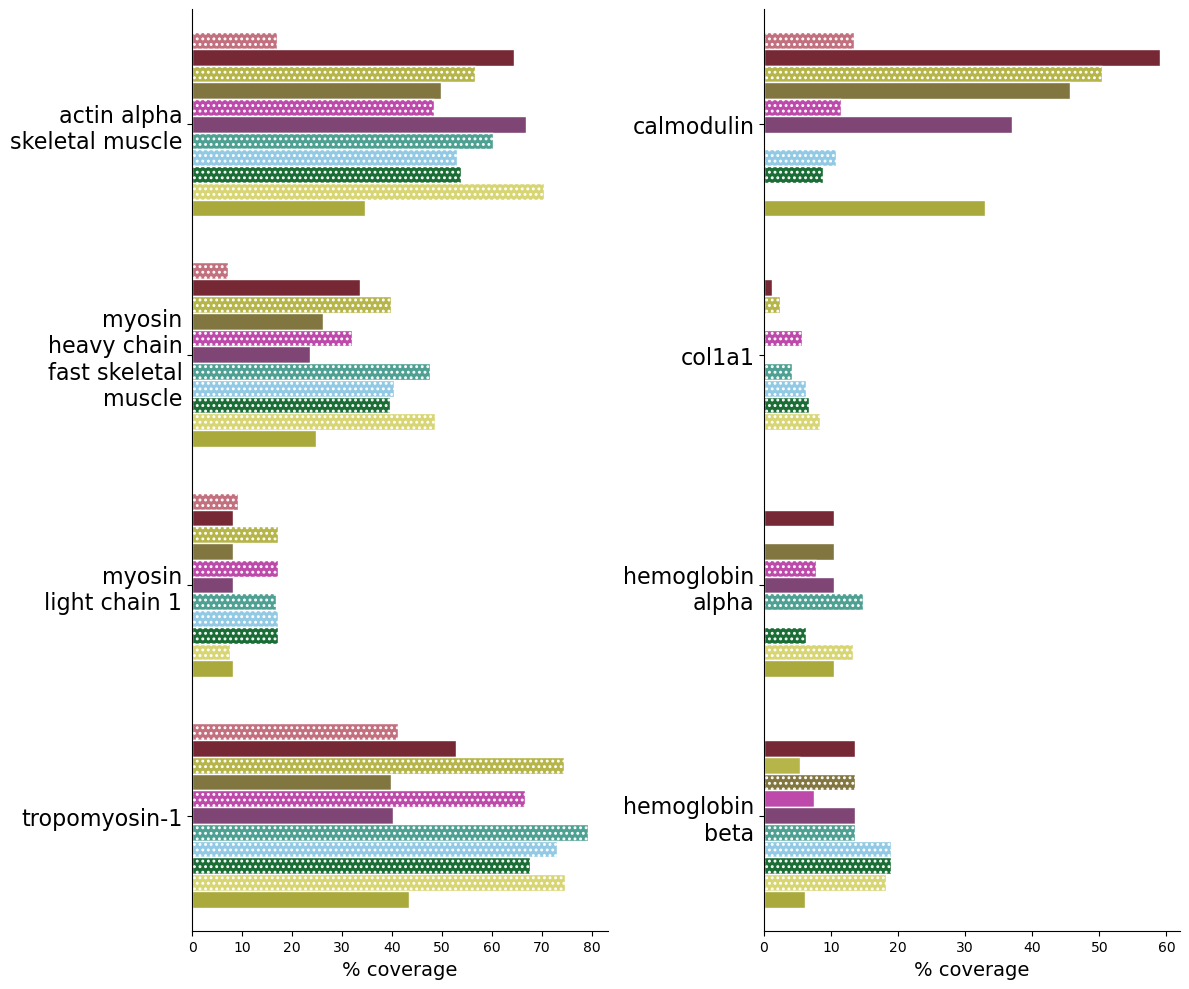

In [53]:
p5 = sns.catplot(
    selec_protein_df.query('cooking == "anchovy"'),
    col='protein_type', col_order = ['muscle', 'other'],
    y='protein_label', x='Coverage', kind='bar', hue='label', palette=briquette_colors,
    sharey=False, sharex=False, hue_order=exp_design['label'].iloc[0:11],
    orient='h', legend_out='full', saturation=0.8)
p5.set_titles(col_template='')
p5.fig.set_figwidth(12)
p5.fig.set_figheight(10)
p5.set_ylabels("", size=12)
p5.set_xlabels("% coverage", size=14)


for i in range(len(p5.axes[0,0].patches)):
    p5.axes[0,0].patches[i].set_hatch(fabric_hatch[ax0hatches[i]])
    p5.axes[0,0].patches[i].set_hatch_linewidth(1.3)
    p5.axes[0,0].patches[i].set_edgecolor('white')

for i in range(len(p5.axes[0,1].patches)):
    p5.axes[0,1].patches[i].set_hatch(fabric_hatch[ax1hatches[i]])
    p5.axes[0,1].patches[i].set_hatch_linewidth(1.3)
    p5.axes[0,1].patches[i].set_edgecolor('white')

for ax in p5.axes[0,:]:
    ax.set_yticklabels(ax.get_yticklabels(), size=16)
    # ax.set_xticklabels(ax.get_xticklabels(), size=12)



# p5.axes[0,1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
p5.axes[0,1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
p5.legend.remove()
export_legend(p5.axes[0,1].get_legend(), os.path.join(save_folder, 'briquettes_legend'))
p5.axes[0,1].get_legend().remove()

p5.fig.tight_layout()
p5.fig.savefig(save_folder + '/coverage_prot_2.png', format='png')
p5.fig.savefig(save_folder + '/coverage_prot_2.svg', format='svg')